# RISE Camp 2018: Introduction to Flor!


Welcome to RISE Camp 2018! Flor is a system for managing workflow development within the machine learning lifecycle. This tool enables data scientists to describe ML workflows as directed acyclic graphs (DAGs) of Actions, Artifacts, or Literals and to experiment with different configurations quickly by running multi-trial experiments. 

![object model](./object_model.png)
<center><i>Artifacts in rectangles; Literals in underline; Actions in circles</i></center>

The purpose of this notebook is to help you use Flor in order to navigate through different parts of the data science lifecycle.

As you work through this notebook, you will learn:

* How to define/use experiments, literals, artifacts and actions.
* How to run experiments with different configurations.
* Compare models with other past versions in order to select the best model.

We will be working with a ratings dataset. Our goal is to predict whether a movie review is positive or negative based on its text.

**Data science is a collaborative activity - we encourage you to work with those around you and ask questions!**

### Prepare your environment before starting the activities.

In [1]:
# Import Flor
import flor
# If the notebook name has not already been set, you are able to set the name in code. 
flor.setNotebookName('tutorial.ipynb')

In [2]:
import florfunctions

In [3]:
%load_ext autoreload
%autoreload 2

**Please make sure that `tutorial/florfunctions.py` is open alongside this notebook.**

In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
movie_reviews = pd.read_json('data.json')
movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], test_size=0.20, random_state=92)

vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
X_tr = vectorizer.transform(X_tr)
X_te = vectorizer.transform(X_te)

In [ ]:
clf = RandomForestClassifier(n_estimators=5).fit(X_tr, y_tr)

y_pred = clf.predict(X_te)

score = clf.score(X_te, y_te)
c = classification_report(y_te, y_pred)

print(score)
print(c)

In [ ]:
clf = RandomForestClassifier(n_estimators=7).fit(X_tr, y_tr)

y_pred = clf.predict(X_te)

score = clf.score(X_te, y_te)
c = classification_report(y_te, y_pred)

print(score)
print(c)

In [4]:
@flor.func
def split_train_and_eval(intermediate_X, intermediate_y, **kwargs):
    import pandas as pd
    import json

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
#     movie_reviews = pd.read_json('data.json')
#     movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

    with open(intermediate_X) as json_data:
        X = json.load(json_data)
        json_data.close()
    with open(intermediate_y) as json_data:
        y = json.load(json_data)
        json_data.close()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=92)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    clf = RandomForestClassifier(n_estimators=5).fit(X_tr, y_tr)
    
    y_pred = clf.predict(X_te)

    score = clf.score(X_te, y_te)
    c = classification_report(y_te, y_pred)

    print(score)
    print(c)
    
    return {'score': score}

In [5]:
with flor.Experiment('risecamp_demo') as ex:
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag="second_preproc")
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag="second_preproc")
    
with flor.Experiment('flor_intro') as ex:
    do_split_train_and_eval = ex.action(split_train_and_eval, [data_x, data_y])
    score = ex.literal(name='score', parent=do_split_train_and_eval)

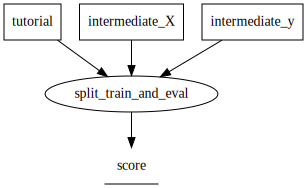

In [6]:
score.plot()

In [7]:
score.pull()

0.722
             precision    recall  f1-score   support

          0       0.73      0.71      0.72      5024
          1       0.72      0.73      0.72      4976

avg / total       0.72      0.72      0.72     10000



In [8]:
flor.Experiment('flor_intro').summarize()

,utag,score,intermediate_y,tutorial,intermediate_X
0,2018-10-05_06-29-49,0.722,data_clean_y_112394719416_139894881723560.json,tutorial_139894881726304.ipynb,data_clean_X_112394722104_139894881725744.json


Cycle back up, what would otherwise be destructive, it is not anymore.

## Context: Introduction & Background

In this tutorial, as in many "real-world" cases, you'll be joining an in-progress model development effort. Bob, a fellow member of your team, has already attempted two different data-preprocessing steps:

In [ ]:
"""
This command just tells flor to summarize the various versions of the experiment named 'risecamp_demo'
"""
flor.Experiment('risecamp_demo').summarize()

Let's interpret the output. The first column, `utag`, lists the different versions of the experiment by name. We can see there are two past versions of the experiment 'risecamp_demo': `first_preproc`, and `second_preproc`. We can also see the artifacts that were involved in the experiment, either as inputs or outputs to some action: `data_loc`, `preprocessing`, `intermediate_X`, and `intermediate_Y`. The name of such artifacts corresponds to the name of the columns in the summary dataframe, we will discuss the values of the cells later in the tutorial. Although we now know there were four (4) artifacts involved in each past version of the experiment, from the summary alone, we cannot (in general) infer how an artifact was produced or consumed in an experiment -- that is, we cannot infer the structure of the experiment computation graph.

Next, we inspect the structure of the experiment computation graph, for each of the two previous versions:

In [ ]:
flor.Experiment('risecamp_demo').plot('first_preproc')

In [ ]:
flor.Experiment('risecamp_demo').plot('second_preproc')

We see that both node-link diagrams look the same. This means that the structure of the different experiment versions is the same; however, it is very likely that the contents of the computation graph differ. To see where the difference is...

In [ ]:
flor.Experiment('risecamp_demo').diff('first_preproc', 'second_preproc')

We see the name `preprocessing` appears in a rectangle and in an ellipse: this means that `preprocessing` is an artifact and an action. This is how we know Flor is tracking the code (e.g. `something.py`), as well as the _execution_ of the code. As in _Make_, the code itself is a dependency to its execution. Next, we see that `data_loc` is an input to `preprocessing`, and `preprocessing` outputs two artifacts: `intermediate_X` and `intermediate_y`.

From this information, we learn that Bob tried two (probably different) preprocessing methods on the source data, and split the preprocessed data into a training matrix, and labels. We can continue to audit Bob with Flor, and this would alone be an interesting and worthwhile activity, but for the purposes of this tutorial, we will start by _using_ the preprocessed data created by Bob, and inspect it only if we need to.

Now, we're ready for the hands-on portion of the tutorial, where we will be training models with Bob's data to predict the polarity (Good, Bad) of English phrases.

## Activity 1: Training a model on each version of the data, followed by data inspection for each version

Earlier we brought ourselves "up to speed" with the preprocessing work that our colleague Bob had undertaken. We learned the `utag` of the past runs (or previous versions), and this name gave us a 'handle' we can use to get a hold of the artifacts that existed or were derived in the past. This means we can use the `intermediate_X` and `intermediate_y` artifacts from the past, rather than having to re-derive them for our activity. 

Here's a reminder of what the previous experiment versions look like:

In [ ]:
flor.Experiment('risecamp_demo').summarize()

## Experiment Setup

Lorem Ipsum

In [ ]:
from florfunctions import traintest_split, train_test

with flor.Experiment('risecamp_demo') as ex:
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag="first_preproc")
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag="first_preproc")
    
    do_split = ex.action(traintest_split, [data_x, data_y])
    
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)
    
    hyperparameter = ex.literal(v = 5, name="hyperparameters")
    
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, hyperparameter])
    
    report = ex.artifact('report.csv', 'report', do_test)
    score = ex.literal(name='score', parent=do_test)


Lorem Ipsum

## Pull

Finally, we are ready to run the experiment! We can do so by running `pull()` on our output artifacts. Before doing this, however, it is helpful to use `plot()` to generate a florplan, a graph representation of the artifact's lineage.

In [ ]:
score.plot()

In [ ]:
#Run the experiment
score.pull('first_pull')

## Pull again, trying a different dataset

In [ ]:
flor.Experiment('risecamp_demo').summarize()

In [ ]:
data_x.version = "second_preproc"
data_y.version = "second_preproc"

In [ ]:
score.plot()

In [ ]:
score.pull('second_pull')

## Compare the reports

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    report = ex.artifact('report.csv', 'report', utag='first_pull')
report.peek()

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    report = ex.artifact('report.csv', 'report', utag='second_pull')
report.peek()

## Compare the data: since it's the only thing that we changed

In [ ]:
with flor.Experiment('risecamp_demo') as ex:
    data_x1 = ex.artifact('data_clean_X.json', 'intermediate_X', utag="first_preproc")
    data_x2 = ex.artifact('data_clean_X.json', 'intermediate_X', utag="second_preproc")

In [ ]:
data_x1.peek()

In [ ]:
data_x2.peek()

## Hyperparameter Tuning

Flor makes it convenient to run models using different hyperparameters and track the results. In the `train_test` we created function, notice that we pass in `hyperparameters` in addition to the train and test data. These hyperparameters will allow us to tune our model and track results with ease; let's define them in our experiment setup.

Notice that the Random Forest Classifier contains `n_estimators` as a hyperparameter. We would like to tune this hyperparameter and track model performance. In order to specify the hyperparameters, we must make a `literalForEach` within our experiment. **Fill in the `literalForEach` with values 5, 50 and 75 within the experiment below.**

In [ ]:
#Note: We have copied the same experiment below for convenience.
#We can also create flor experiments using a context manager.

# Create a context manager for the experiment and is named 'risecamp_demo'
with flor.Experiment('risecamp_demo') as ex:

    # Defines artifacts
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag='second')
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag='second')

    #Define split action and resulting output artifacts
    do_split = ex.action(traintest_split, [data_x, data_y])
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)

    #Define the hyperparameters for the models
    random_forest_Nestimators = ex.literal(v = 5, name="hyperparameters")
#     random_forest_Nestimators = ex.literalForEach(v=[5, 10, 15], name="hyperparameters", default=5) #SOLUTION

    #Define the model training and evaluation action and final artifacts
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, random_forest_Nestimators])
    report = ex.artifact('report.csv', 'report', do_test)
    score = ex.literal(name='score', parent=do_test)


In [ ]:
score.plot()

In [ ]:
#Run the experiment
score.pull(utag="hyperparameter_tuning")

## Summarizing Results

After running the model with different hyperparameters above, we are able to peek at our output artifact, containing precision and recall metrics for the different models. Run the following cell - **which hyperparameter yields the best model?**

In [ ]:
import flor
flor.Experiment('risecamp_demo').summarize()

## Building a Better Model

Now that you have some experience using flor, let's try using a different model to see if we can improve the results. Some of the classifiers we recommend trying are the Multilayer Perceptron Classifier, Naive Bayes Classifier, and K-neighbors Classifier.

After implementing your model of choice in the `train_test` function in **florfunctions.py**, run the cells below to reimport the function and run the experiment.

In [ ]:
from florfunctions import train_test

In [ ]:
#Note: We have copied the same experiment below for convenience.
#We can also create flor experiments using a context manager.

# Create a context manager for the experiment and is named 'risecamp_demo'
with flor.Experiment('risecamp_demo') as ex:
    # Defines artifacts
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag='first')
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag='first')

    #Define split action and resulting output artifacts
    do_split = ex.action(traintest_split, [data_x, data_y])
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)

    #Define the hyperparameters for the models
    #hyperparameter = ex.literal(v = 5, name="hyperparameters")
    random_forest_Nestimators = ex.literalForEach(v=[5, 10, 15], name="hyperparameters", default=5) #SOLUTION
    #MLP_hidden_layer_size = ex.literalForEach(v=[(1, ), (2, ), (3, )], name="hyperparameters", default=(2, ))

    #Define the model training and evaluation action and final artifacts
    #change to MLP_hidden_layer_size 
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, random_forest_Nestimators])
    #for naive bayes
    #do_test = ex.action(train_test, [X_train, X_test, y_train, y_test])
    report = ex.artifact('report.csv', 'report', do_test)
    score = ex.literal(name='score', parent=do_test)


In [ ]:
score.plot()

In [ ]:
score.pull(utag="improved_model")

In [ ]:
flor.Experiment('risecamp_demo').summarize()

## Of all the things we tried, what helped the most?

In [ ]:
flor.Experiment('risecamp_demo').summarize().cube()